FINAL PROJECT FEATURE EXTRACTION

In [ ]:
!pip install --upgrade pip setuptools
!pip install numpy
!pip install essentia mirdata pandas

import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mirdata-0.3.7-py3-none-any.whl (14.9 MB)
  Using cached jams-0.3.4.tar.gz (51 kB)
  Preparing metadata (setup.py) ... done
  Using cached pretty_midi-0.2.10.tar.gz (5.6 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=ebec7e03370892fa79ab4be32ca668e80f2ac14e17dcab85184e1511c58ecb43
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
  C

In [ ]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
goodsounds = mirdata.initialize("good_sounds", data_home="/content/drive/MyDrive/MIR/good_sounds")
#goodsounds.download()
goodsounds.validate

<bound method Dataset.validate of The good_sounds dataset
----------------------------------------------------------------------------------------------------


Call the .cite method for bibtex citations.
----------------------------------------------------------------------------------------------------


GOOD-SOUNDS Track class

    Args:
        track_id (str): track id of the track

    Attributes:
        audio_path (str): Path to the audio file

    Cached Properties:
        ratings_info (dict):  A dictionary containing the entity Ratings.
        Some musicians self-rated their performance in a 0-10 goodness scale for the user evaluation of the first project
        prototype. Please read the paper for more detailed information.
            - id
            - mark: the rate or score.
            - type: the klass of the sound. Related to the tags of the sound.
            - created_at
            - comments
            - sound_id
            - rater: the musician who rated the 

In [ ]:
# Informations about the dataset
goodsounds_ids = goodsounds.track_ids  # Load IDs
goodsounds_data = goodsounds.load_tracks()  # Load  data
print('number of elements in the dataset:', len(goodsounds_ids))
# Visualize a random track
sound = goodsounds.choice_track()
print(f'Track id: {sound.track_id}')
print(f'Quality and/or articulation: {sound.klass}')
print(f'Intstrument: {sound.instrument}')



number of elements in the dataset: 16308
Track id: 4323
Quality and/or articulation: bad-attack-pitch-up
Intstrument: trumpet


In [ ]:
# Let's see all the quality/articulation classes 
klass_names = []
for i in goodsounds_ids:
    #not all sounds have a "klass"
    if goodsounds_data[i].klass == None:
      goodsounds_data[i].klass = 'None'
    klass_names.append(goodsounds_data[i].klass)
klass_names = np.unique(klass_names)
print(klass_names)

['' ' good-sound-pizzicato-hard' ' good-sound-pizzicato-soft' 'None'
 'air-inside' 'air-outside' 'bad-air' 'bad-attack'
 'bad-attack bad-richness' 'bad-attack bad-richness bad-timbre'
 'bad-attack bad-timbre bad-richness' 'bad-attack-air' 'bad-attack-gallo'
 'bad-attack-multiphonic' 'bad-attack-pitch-down' 'bad-attack-pitch-up'
 'bad-attack-pressure' 'bad-attack-rebond' 'bad-attack-tongue'
 'bad-attack-tongue-block' 'bad-attack-too-strong' 'bad-dynamic-stability'
 'bad-dynamics' 'bad-dynamics bad-timbre'
 'bad-dynamics-bad-timbre-bad-pitch' 'bad-dynamics-crescendo'
 'bad-dynamics-decrescendo' 'bad-dynamics-errors'
 'bad-dynamics-stability-crescendo' 'bad-dynamics-stability-decrescendo'
 'bad-dynamics-stability-errors' 'bad-dynamics-stability-tremolo'
 'bad-dynamics-tremolo' 'bad-pitch' 'bad-pitch bad-dynamics bad-timbre'
 'bad-pitch bad-timbre' 'bad-pitch bad-timbre bad richness'
 'bad-pitch-bad-timbre-notune' 'bad-pitch-errors' 'bad-pitch-stability'
 'bad-pitch-stability-bend' 'bad-pi

In [ ]:
# Before preprocess let's select the higher quality sounds in the dataset since we have seen that there are many sounds categorised as "bad"
# Let's create a dictonary using klass (Quality/articulation) as keys
klass_dict = {item: [] for item in klass_names}
for i in goodsounds_ids:
    klass_dict[goodsounds_data[i].klass].append(goodsounds_data[i])
#klass_dict['good-sound-bow'] #for example
# And select just enough of the good sounding samples
good_ones1 = klass_dict['good-sound']
print('good-sound lenght: ', len(good_ones1))
good_ones2 = klass_dict['good-sound-bow']
print('good-sound-bow: ', len(good_ones2))
good_ones = good_ones1 + good_ones2
del klass_dict
print(len(good_ones), 'are gonna be enough samples')




good-sound lenght:  2705
good-sound-bow:  80
2785 are gonna be enough samples


In [ ]:
# Since there are redundant sounds because they are recorded with 3 different microphones, let's select just the neumann ones.
microphones = []
for i in good_ones:
    microphones.append(i.microphone)
microphones = np.unique(microphones)
microphones_dict = {item: [] for item in microphones}
for i in good_ones:
    microphones_dict[i.microphone].append(i)
neumannU87 = microphones_dict['neumann']  # This is now our filtered dataset
del microphones_dict

# Define the new tags
wood_tags = ['bass', 'cello', 'oboe', 'piccolo', 'violin']
metal_tags = ['flute', 'sax_alto', 'sax_baritone', 'sax_soprano', 'sax_tenor', 'trumpet']
clarinet_tag = 'clarinet'

# Add tags to each sample based on the material
sample_tags = {}  # Dictionary to store tags for each sample
for i in neumannU87:
    tags = []
    if i.instrument in wood_tags:
        tags.extend(['wood', i.instrument])
    elif i.instrument in metal_tags:
        tags.extend(['metal', i.instrument])
    elif i.instrument == clarinet_tag:
        tags.extend(['plastic and wood', i.instrument])
    sample_tags[i.audio_path] = tags

# Count the samples for each material and ensure the new tags are used as keys in material_dict
material_dict = {tag: [] for tag in np.unique(np.concatenate([tags[:-1] for tags in sample_tags.values()]))}
for audio_path, tags in sample_tags.items():
    material_dict[tags[-2]].append(audio_path)

# Display the counts for each material
materials = np.unique(list(material_dict.keys()))
print(f"We have the following materials in the dataset: {materials}")
for material in materials:
    print(f"In total there are {len(material_dict[material])} {material}")



We have the following materials in the dataset: ['metal' 'plastic and wood' 'wood']
In total there are 629 metal
In total there are 219 plastic and wood
In total there are 478 wood


Plot waveforms of the first sample of each material:


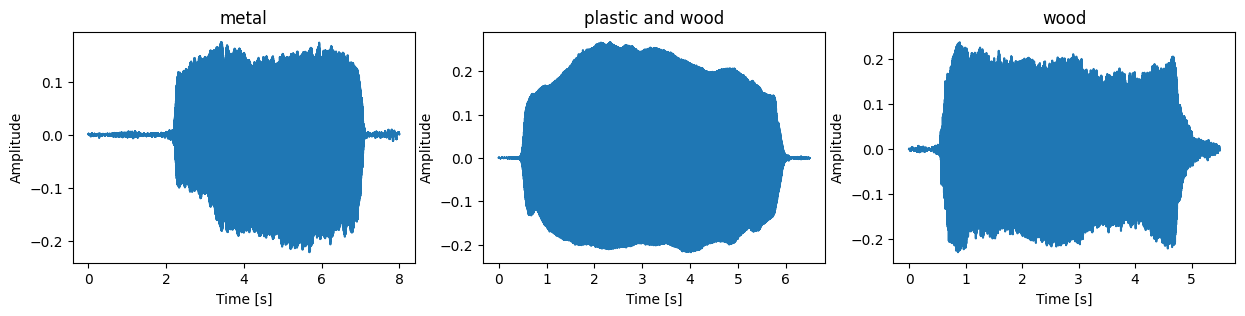

In [ ]:
# We plot the waveform of the first sound in each material category
_, fs = neumannU87[0].audio
num_sounds = len(material_dict.keys())
print("Plot waveforms of the first sample of each material:")
plt.figure(1, figsize=(5 * num_sounds, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, inst_name in enumerate(material_dict.keys()):
    sample_file = material_dict[inst_name][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    t_max = len(x) / fs
    t = np.linspace(0, t_max, x.size)
    plt.subplot(1, num_sounds, (i+1))
    plt.plot(t, x)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(inst_name)


## Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

In the downloaded dataset, recordings include a sequence of isolated notes played in sequence which could be split into isolated notes. We would like to investigate the option of splitting using a fixed energy threshold (which would help us seperate notes using the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


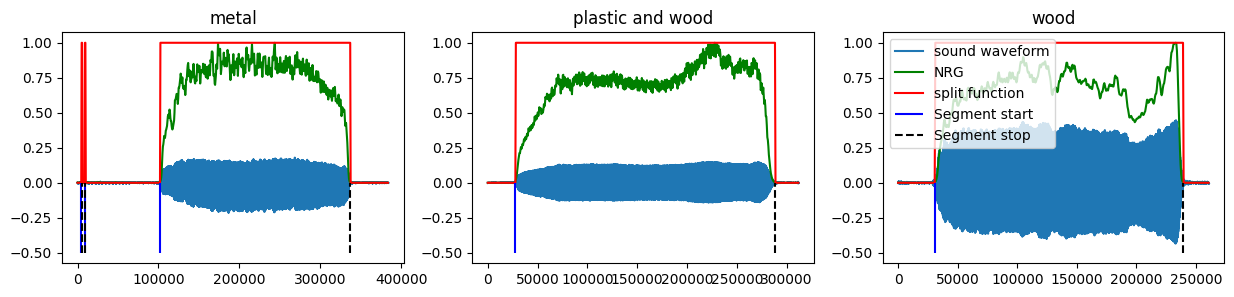

In [ ]:
num_material = len(materials)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_material, 3))
    for i, material in enumerate(material_dict.keys()):
        sample_file = material_dict[material][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_material,(i+1))
        plt.title(material)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')
plt.legend(loc="best");

In [ ]:
#Create the directory for segmenting
main_data_dir = '/content/drive/MyDrive/MIR' #General directory, not in good sounds folder
if not os.path.exists(main_data_dir): 
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir):
    os.mkdir(segments_dir)

In [ ]:
# Let's create segments and save them in segments folders with number of recording and name of the materials

from pathlib import Path

segment_files = {item: [] for item in materials}
for material, files in material_dict.items():
  for sample_file in files:
    #Get file ID
    sound_id = material + '_' + Path(sample_file).parts[-1]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
    #Croping segments
    for start, stop in zip(start_indexes, stop_indexes):
        x_seg = x[start: stop]
        #Final check for amplitude (to avoid silent segments selection due to noise in split function)
        if(np.max(np.abs(x_seg)) > 0.05):
            #Amplitude normalisation
            x_seg = x_seg / np.max(np.abs(x_seg))
            filename = os.path.join(segments_dir, sound_id)
            ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
            segment_files[material].append(filename)
print('Done with segmenting')







Done with segmenting


## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [ ]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(goodsounds_data['8757'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:
# Writing the features extracted in the data.csv file in the MIR folder
data_file = '/content/drive/MyDrive/MIR/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for key in segment_files.keys():
      for filename in segment_files[key]:
          file_count +=1
          if file_count % 20 == 0: #print name of a file every 20 files
              print(file_count, "files processed, current file: ", filename)

          #Compute and write features for file
          features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                        lowlevelFrameSize = 2048,
                                                        lowlevelHopSize = 1024,
                                                        lowlevelStats = ['mean', 'stdev'])(filename)
          selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
          label = filename.split('/')[-1].split('.')[0].split('_')[0]
          line2write = str(selected_features)[1:-1] + ',' + label + '\n'
          writer.write(line2write)
print("A total of ", file_count, "files processed")




20 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0019.wav
40 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0039.wav
60 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0059.wav
80 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0077.wav
100 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0023.wav
120 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0047.wav
140 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0067.wav
160 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0000.wav
180 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0020.wav
200 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0040.wav
220 files processed, current file:  /content/drive/MyDrive/MIR/segments/metal_0060.wav
240 files processed, current file:  /content/dr

In [ ]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.986293,12.452486,1.201626,0.352302,0.028525,0.927201,1.354072,0.937230,0.243236,6.485027,...,48.693039,4.171433,1.502981,1447651.125,1422395.750,1.344614,0.428993,0.025818,0.004942,metal
1,0.977158,8.924804,1.229572,0.400484,0.038548,-0.034444,0.468423,0.181328,0.168854,6.397902,...,47.068962,3.692173,1.394908,1561050.000,1859412.750,2.879936,1.004796,0.029616,0.003395,metal
2,0.979781,11.657586,2.712592,0.459572,0.045677,0.387988,4.472599,0.058800,0.262954,5.524896,...,59.127754,4.954931,2.103185,1314210.000,1724750.875,3.593501,0.900548,0.021587,0.002471,metal
3,0.983553,10.479261,1.205621,0.410602,0.031244,0.919722,0.959755,0.035606,0.155818,4.422903,...,40.998272,4.822572,1.770701,1323757.500,347317.500,3.973312,0.926922,0.034066,0.004130,metal
4,0.983356,9.640859,0.989395,0.391820,0.039746,0.469115,0.736123,0.160384,0.227850,4.834016,...,85.387505,4.719386,2.091356,1601151.500,2338826.250,2.784056,0.601021,0.030516,0.006059,metal


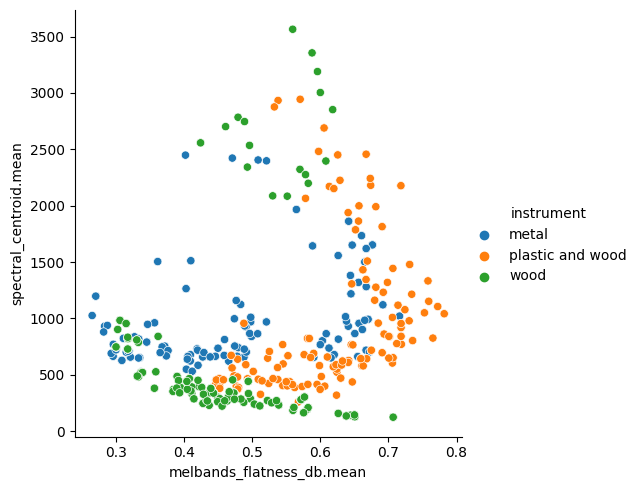

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data);

### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [ ]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.instrument.value_counts()

metal               617
wood                466
plastic and wood    209
Name: instrument, dtype: int64

In [ ]:
# We choose 'plastic and wood' to balance the number, since it's the smallest number 

# We choose oboe instead of "cha" to balance the number, since it's the smallest number 
min_number = data_modif.instrument.value_counts()['plastic and wood']
metal_data = data_modif[data_modif.instrument == 'metal'].sample(n = min_number)
wood_data = data_modif[data_modif.instrument == 'wood'].sample(n = min_number)
plasticandwood_data = data_modif[data_modif.instrument == 'plastic and wood']

#Merging after downsampling
data_modif = pd.concat([plasticandwood_data, wood_data, metal_data])
#Checking the balance again
data_modif.instrument.value_counts()




plastic and wood    209
wood                209
metal               209
Name: instrument, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [ ]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [9.89959875e-01 2.98109110e-01 3.55686451e-01 2.59200581e-01
 9.09755662e-02 2.36149979e-03 1.30351393e-02 5.51596372e-02
 1.21002756e-01 3.65016986e-01 2.45654971e-01 2.60506260e-01
 3.62142114e-01 1.12846618e-01 3.42841028e-01 2.71792736e-01
 2.94718008e-01 1.48084322e-01 4.04915894e-02 8.62402650e-02
 7.06908869e-02 3.04851441e-01 3.00526194e-01 5.65829913e-01
 2.88956074e-01 1.07492570e-01 4.84470050e-01 1.50446512e-01
 4.97305993e-01 1.82688627e-01 5.84891429e-01 1.68558799e-01
 4.32771748e-01 3.04755688e-01 3.60797461e-01 9.31916724e-02
 2.31846179e-02 3.50583999e-01 1.22600477e-01 3.43546744e-01
 3.68764964e-01 2.43262141e-01 5.72830677e-01 4.37532157e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 5.43429672e-02 1.95692861e-01 9.97646507e-02 1.55711747e-01
 3.00822556e-01 3.00922147e-01 7.77841983e-01 1.21574537e-01
 2.23639853e-01 1.18763698e-01 7.99936023e-04 1.26168240e-03
 1.13274155e-01 5.85906573e-02 5.24094303e-02 4.089111

In [ ]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (420, 84) , Size of train output vector:  (420,)
Size of test features matrix:  (207, 84) , Size of test output vector:  (207,)


In [ ]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test), 'good accuracy')

accuracy:  0.961352657004831 good accuracy


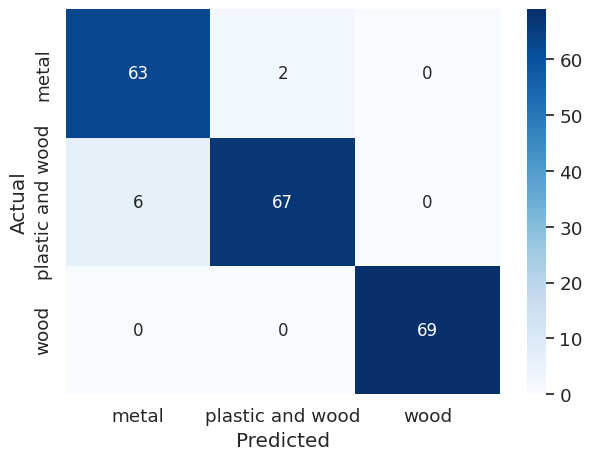

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (501, 3)
One-hot encoded y_test shape =  (126, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 8))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [ ]:
model.summary()  # Plot summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization_2 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 40)                0         
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)               

In [ ]:

model.add(layers.Dense(name='OutputLayer', units=3))
model.add(layers.Activation('sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size=50, epochs=250, validation_split=0.2, verbose=0)


In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07726224511861801
Test accuracy: 0.9682539701461792


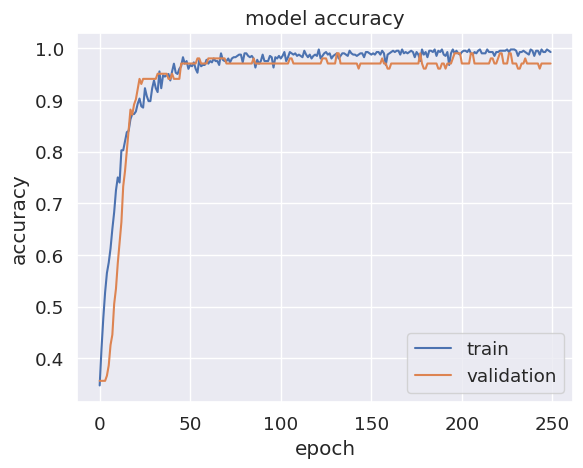

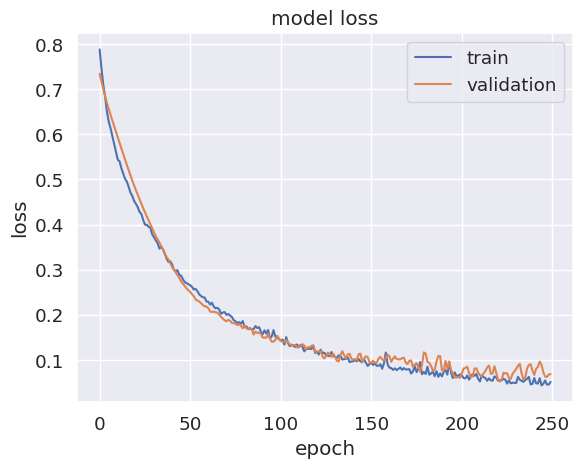

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()